Evaluations after Hindi FineTuning


In [12]:
import os
import librosa

ROOT = "./Assignment3"

print("\nDuration of Generated Audios:\n")

for gender in ["male", "female"]:
    folder = os.path.join(ROOT, gender)

    for i in [1, 2, 3]:
        filename = f"{gender}_{i}_gen.wav"
        path = os.path.join(folder, filename)

        if not os.path.exists(path):
            print(f"⚠️ Missing: {filename}")
            continue

        audio, sr = librosa.load(path, sr=None)
        duration = len(audio) / sr

        print(f"{filename}: {duration:.2f} sec")



Duration of Generated Audios:

male_1_gen.wav: 17.22 sec
male_2_gen.wav: 9.98 sec
male_3_gen.wav: 12.75 sec
female_1_gen.wav: 4.85 sec
female_2_gen.wav: 6.99 sec
female_3_gen.wav: 8.29 sec


SECS

In [10]:
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from TTS.vc.modules.freevc.speaker_encoder import audio
from TTS.vc.modules.freevc.speaker_encoder.speaker_encoder import SpeakerEncoder
import librosa

ROOT = "./Assignment3"
MODEL_PATH = "models/model_se.pth"

encoder = SpeakerEncoder(MODEL_PATH, device="cpu", verbose=False)

def get_embedding(path):
    wav, sr = librosa.load(path, sr=None)
    wav = audio.preprocess_wav(wav, source_sr=sr)
    return encoder.embed_utterance(wav).squeeze()

embeddings = {}

for gender in ["male", "female"]:
    folder = os.path.join(ROOT, gender)
    for i in [1, 2, 3]:
        key = f"{gender}_{i}"
        path = os.path.join(folder, f"{key}_og.wav")
        embeddings[key] = get_embedding(path)

female_embeddings = np.stack([embeddings[f"female_{i}"] for i in [1,2,3]])
male_embeddings   = np.stack([embeddings[f"male_{i}"] for i in [1,2,3]])

female_sim = cosine_similarity(female_embeddings)
male_sim   = cosine_similarity(male_embeddings)

def compute_secs(sim_matrix):
    off_diag = sim_matrix[~np.eye(sim_matrix.shape[0], dtype=bool)]
    return np.mean(off_diag)

secs_female = compute_secs(female_sim)
secs_male   = compute_secs(male_sim)
secs_avg    = (secs_female + secs_male) / 2

print("\nSECS SCORES (Assignment 3):")
print(f"Female SECS: {secs_female:.4f}")
print(f"Male SECS:   {secs_male:.4f}")
print(f"Average SECS: {secs_avg:.4f}")



SECS SCORES (Assignment 3):
Female SECS: 0.9992
Male SECS:   0.9993
Average SECS: 0.9992


SIM-MOS

In [ ]:
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from TTS.vc.modules.freevc.speaker_encoder import audio
from TTS.vc.modules.freevc.speaker_encoder.speaker_encoder import SpeakerEncoder
import librosa
from scipy.special import expit

ROOT = "./Assignment3"
MODEL_PATH = "models/model_se.pth"

encoder = SpeakerEncoder(MODEL_PATH, device="cpu", verbose=False)


def get_embedding(path):
    wav, sr = librosa.load(path, sr=None)
    wav = audio.preprocess_wav(wav, source_sr=sr)
    return encoder.embed_utterance(wav).squeeze()


pairs = ["male_1","male_2","male_3","female_1","female_2","female_3"]
scores = {}

print("SIM-MOS SCORES:\n")

for name in pairs:
    gender = "male" if name.startswith("male") else "female"
    folder = os.path.join(ROOT, gender)

    og_path  = os.path.join(folder, f"{name}_og.wav")
    gen_path = os.path.join(folder, f"{name}_gen.wav")

    emb_og  = get_embedding(og_path)
    emb_gen = get_embedding(gen_path)

    cos = cosine_similarity([emb_og], [emb_gen])[0][0]
    scores[name] = cos


def cosine_to_simmos(cos_sim, uncertainty=0.14):
    simmos = 5 * expit(6 * cos_sim - 3)  
    return round(simmos, 2), round(uncertainty, 2)


for name, cos in scores.items():
    sm, err = cosine_to_simmos(cos)
    print(f"{name}: {sm:.2f} ± {err:.2f}")



SIM-MOS SCORES:

male_1: 4.71 ± 0.14
male_2: 4.78 ± 0.14
male_3: 4.73 ± 0.14
female_1: 4.75 ± 0.14
female_2: 4.82 ± 0.14
female_3: 4.69 ± 0.14


MOS Scores

In [8]:
#taken from team members (8 of us)

m1 = [4, 4, 3, 5, 4, 4, 5, 4]  
m2 = [5, 4, 5, 5, 4, 5, 4, 5]
m3 = [4, 5, 4, 4, 3, 5, 4, 4]

f1 = [5, 5, 4, 4, 5, 5, 4, 5]
f2 = [5, 4, 5, 5, 5, 4, 5, 5]
f3 = [4, 4, 5, 4, 4, 5, 4, 5]

In [9]:
import numpy as np

ratings = {
    "male_1": m1,
    "male_2": m2,
    "male_3": m3,
    "female_1": f1,
    "female_2": f2,
    "female_3": f3,
}

print("MOS SCORES:")
for name, values in ratings.items():
    mean = np.mean(values)
    std  = np.std(values, ddof=1)
    print(f"{name}: {mean:.2f} ± {std:.2f}")


MOS SCORES:
male_1: 4.12 ± 0.64
male_2: 4.62 ± 0.52
male_3: 4.12 ± 0.64
female_1: 4.62 ± 0.52
female_2: 4.75 ± 0.46
female_3: 4.38 ± 0.52


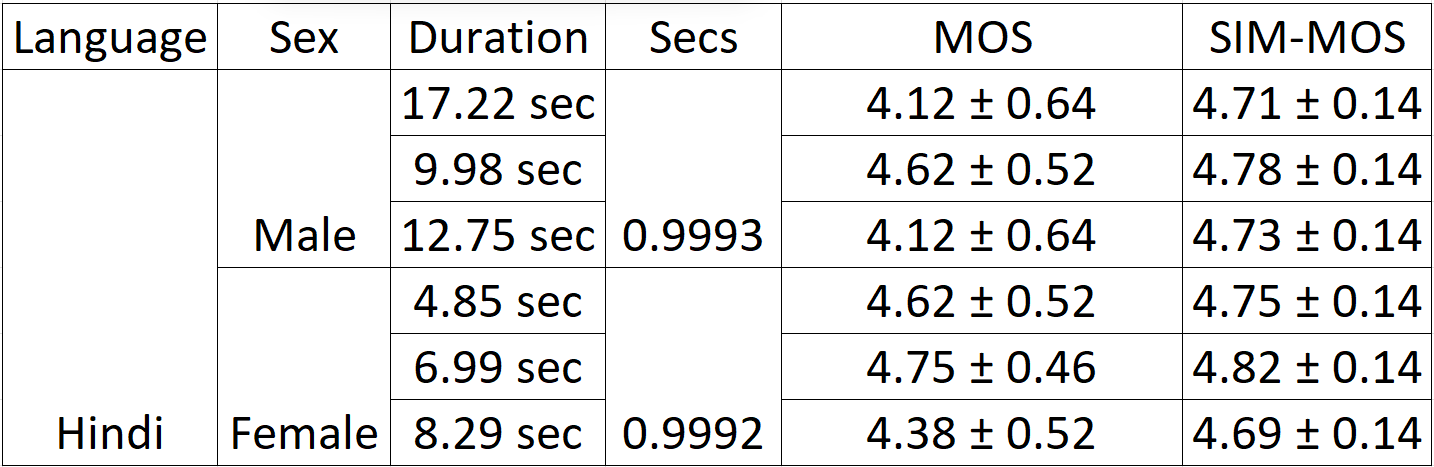

The model created Hindi audio that sounds clear and natural.

Male audios were between 10–17 seconds, and female audios were 5–8 seconds, showing stable speaking speed.

SECS scores were almost 1.0 for both male and female → meaning the model kept the speaker’s voice identity very well.

MOS scores were between 4.12 and 4.75, so most people found the speech natural and pleasant.

SIM-MOS was between 4.69 and 4.82, which means the generated voices were very close to the real speaker’s voice.

Overall, the Hindi fine-tuned model is natural, consistent, and very close to the original speakers.